<a href="https://colab.research.google.com/github/HieuNguyen-coder/Mask_and_distance/blob/main/Train_mask_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import module

In [ ]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.2 MB/s 


In [ ]:
import cv2
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Zalo_train/train_meta.csv')
df_mask = df[['fname', 'mask']]
df_mask = pd.DataFrame(df_mask.query('mask==0 or mask==1'))
mp_face_detection = mp.solutions.face_detection
images_path = '/content/drive/MyDrive/Zalo_train/images/'

# Crop faces in the images to create dataset

In [ ]:
train_faces, train_labels = [], []
for line in tqdm(np.array(df_mask)):
  image_path = os.path.join(images_path, line[0])
  with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_detection.process(image)
    if results.detections:
      for detection in results.detections:
        try:
          x = int(detection.location_data.relative_bounding_box.xmin*image.shape[1])
          y = int(detection.location_data.relative_bounding_box.ymin*image.shape[0])
          w = int(detection.location_data.relative_bounding_box.width*image.shape[1])
          h = int(detection.location_data.relative_bounding_box.height*image.shape[0])
          tmp_image = image[y:y+h, x:x+w]
          tmp_image = cv2.resize(tmp_image, (128, 128))/255.0
          train_faces.append(tmp_image)
          train_labels.append(line[1])
        except:
          continue

100%|██████████| 3441/3441 [05:55<00:00,  9.69it/s]


# Display some faces

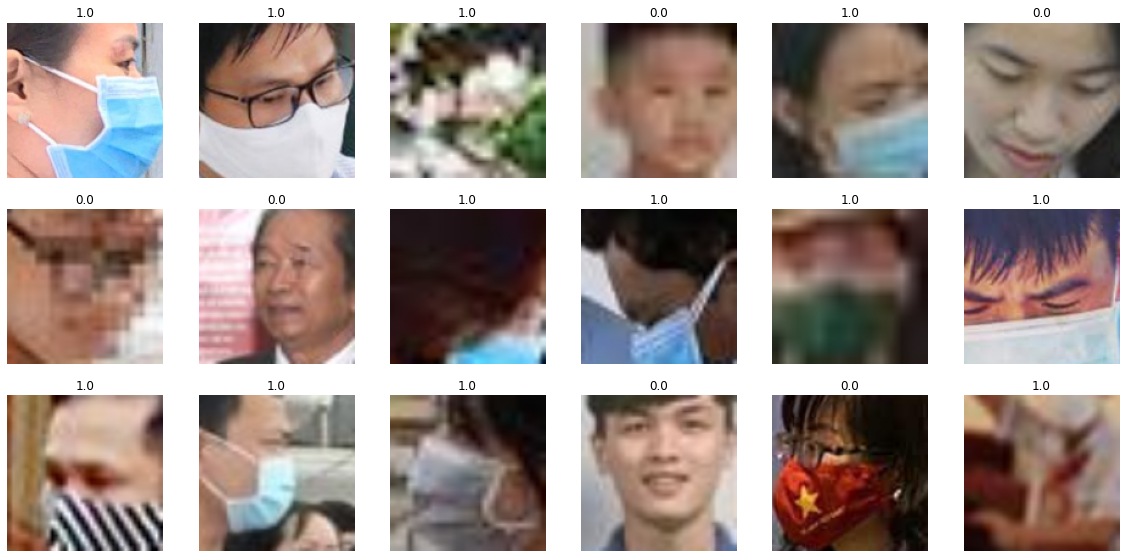

In [ ]:
fig = plt.figure(figsize=(20, 20))
for n , i in enumerate(list(np.random.randint(0,len(train_labels),18))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(train_faces[i])   
    plt.axis('off')
    plt.title(train_labels[i])

# Balance dataset

In [ ]:
print('The number of label "0":', train_labels.count(0))
print('The number of label "1":', train_labels.count(1))

The number of label "0": 1835
The number of label "1": 2685


In [ ]:
max_num = min(train_labels.count(0), train_labels.count(1))*1.2
X, y = [], []
for i in range(len(train_labels)):
  if (train_labels[i]==0 and y.count(0)<=max_num) or (train_labels[i]==1 and y.count(1)<=max_num):
    y.append(train_labels[i])
    X.append(train_faces[i])

# Convert into numpy array

In [ ]:
X = np.array(X)
y = np.array(y)

# Split into train and valid sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4)

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

# Define and train model

In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy')>0.9):
            print('\nStop training :)))')
            self.model.stop_training = True

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

xception = Xception(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in xception.layers:
  layer.trainable = False

model = Sequential([
  data_augmentation,
  xception,
  Dropout(0.2),
  Flatten(),
  Dense(2, activation='sigmoid')
])

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(
  optimizer=adam,
  loss="sparse_categorical_crossentropy",
  metrics = ["accuracy"]
)

In [ ]:
callback = myCallback()
history = model.fit(
    X_train, 
    y_train,
    epochs = 20,
    steps_per_epoch = 20,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [callback]
)

Epoch 1/20
20/20 [==============================] - 236s 12s/step - loss: 0.5451 - accuracy: 0.7258 - val_loss: 0.3372 - val_accuracy: 0.8577
Epoch 2/20
20/20 [==============================] - 228s 12s/step - loss: 0.4030 - accuracy: 0.8315 - val_loss: 0.3212 - val_accuracy: 0.8688
Epoch 3/20
20/20 [==============================] - 228s 12s/step - loss: 0.3808 - accuracy: 0.8448 - val_loss: 0.3218 - val_accuracy: 0.8626
Epoch 4/20
20/20 [==============================] - 229s 12s/step - loss: 0.3802 - accuracy: 0.8472 - val_loss: 0.3172 - val_accuracy: 0.8632
Epoch 5/20
20/20 [==============================] - 230s 12s/step - loss: 0.3583 - accuracy: 0.8538 - val_loss: 0.3036 - val_accuracy: 0.8793
Epoch 6/20
20/20 [==============================] - 230s 12s/step - loss: 0.3472 - accuracy: 0.8571 - val_loss: 0.2984 - val_accuracy: 0.8731
Epoch 7/20
20/20 [==============================] - 231s 12s/step - loss: 0.3351 - accuracy: 0.8629 - val_loss: 0.2968 - val_accuracy: 0.8756
Epoch 

In [ ]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

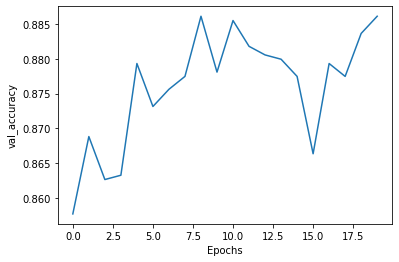

In [ ]:
plot_graph(history, 'val_accuracy')

In [ ]:
# model.save('/content/drive/MyDrive/model_Xception.h5')